# Importing Libraries

In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

# Configuration

In [2]:
@dataclass
class CONFIG:
    debug: bool = False

    # Model
    vocab_size: int = None
    ## Bigram
    d_embed_bigram: int = 64
    ## Transformer
    model_size: str = 'large'  # 'small' or 'large'
    ### Small
    if model_size == 'small':
        context_size: int = 32
        n_layers: int = 3
        n_heads: int = 4
        d_embed: int = 64
        d_ff: int = d_embed * 4
        dropout: float = 0.1
    ### Large
    elif model_size == 'large':
        context_size: int = 32
        n_layers: int = 6
        n_heads: int = 4
        d_embed: int = 64
        d_ff: int = d_embed * 4
        dropout: float = 0.2

    flash_attention: bool = False
    
    # Dataset
    dataset_path: str = 'data/'
    dtype: torch.dtype = torch.long
    validation_size: float = 0.2
    
    # Device
    device: torch.device = None
    
    # Training
    epochs: int = 10
    batch_size: int = 2048
    learning_rate: float = 2e-5
    
    # Generation
    max_new_tokens: int = 1000
    temperature: float = 1.0
    
    # Seed
    seed: int = 101

# Reproducibility

In [3]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f"Seed: {seed}")
    
set_seed(CONFIG.seed)

Seed: 101


# Device

In [4]:
def configure_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        num_gpu = torch.cuda.device_count()
        print("> Running on GPU", end=' | ')
        print("Num of GPUs: ", num_gpu)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("> Running on MPS")
    else:
        device = torch.device("cpu")
        print("> Running on CPU")
    return device

CONFIG.device = configure_device()

> Running on GPU | Num of GPUs:  1


# Debug

In [5]:
if CONFIG.debug:
    CONFIG.epochs = 1
    CONFIG.max_new_tokens = 100

# Dataset

In [6]:
shakespeare_dataset = CONFIG.dataset_path + 'shakespeare.txt'

In [7]:
with open(shakespeare_dataset, 'r', encoding='utf-8') as f:
    shakespeare_text = f.read()

In [8]:
if CONFIG.debug:
    print(shakespeare_text[:1000])
    print(f'Total number of characters in the text: {len(shakespeare_text)}')

In [9]:
chars = list(set(shakespeare_text))
chars.append('\0')  # Padding token
chars.sort()
vocab_size = len(chars)
CONFIG.vocab_size = vocab_size
print(f'Unique characters: {chars}')
print(f'Total number of unique characters: {vocab_size}')

Unique characters: ['\x00', '\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total number of unique characters: 66


# Tokenization (Character Level)

In [10]:
char_to_int = {c: i for i, c in enumerate(chars)}
encode = lambda s: [char_to_int[c] for c in s]
int_to_char = {i: c for i, c in enumerate(chars)}
decode = lambda l: "".join([int_to_char[int(i)] for i in l])
print(f'Character to integer mapping: {char_to_int}')
print(f'Integer to character mapping: {int_to_char}')

Character to integer mapping: {'\x00': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '&': 5, "'": 6, ',': 7, '-': 8, '.': 9, '3': 10, ':': 11, ';': 12, '?': 13, 'A': 14, 'B': 15, 'C': 16, 'D': 17, 'E': 18, 'F': 19, 'G': 20, 'H': 21, 'I': 22, 'J': 23, 'K': 24, 'L': 25, 'M': 26, 'N': 27, 'O': 28, 'P': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'W': 36, 'X': 37, 'Y': 38, 'Z': 39, 'a': 40, 'b': 41, 'c': 42, 'd': 43, 'e': 44, 'f': 45, 'g': 46, 'h': 47, 'i': 48, 'j': 49, 'k': 50, 'l': 51, 'm': 52, 'n': 53, 'o': 54, 'p': 55, 'q': 56, 'r': 57, 's': 58, 't': 59, 'u': 60, 'v': 61, 'w': 62, 'x': 63, 'y': 64, 'z': 65}
Integer to character mapping: {0: '\x00', 1: '\n', 2: ' ', 3: '!', 4: '$', 5: '&', 6: "'", 7: ',', 8: '-', 9: '.', 10: '3', 11: ':', 12: ';', 13: '?', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'O', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: '

In [11]:
shakespeare_tokens = torch.tensor(encode(shakespeare_text), dtype=CONFIG.dtype)

In [12]:
if CONFIG.debug:
    print(f"Sample text: {shakespeare_text[:10]}")
    print(f"Sample tokens: {shakespeare_tokens[:10]}")
    print(f"Sample decoded text: {decode(shakespeare_tokens[:10])}")
    print(f"Total number of characters: {len(shakespeare_text)}")
    print(f"Total number of tokens: {len(shakespeare_tokens)}")
    print(f"Total number of unique tokens: {len(torch.unique(shakespeare_tokens))}")
    print(f"dtype: {shakespeare_tokens.dtype}")

# Preprocessing

In [13]:
# Train Validation Split
train_size = int(len(shakespeare_tokens) * (1 - CONFIG.validation_size))
train_tokens = shakespeare_tokens[:train_size]
validation_tokens = shakespeare_tokens[train_size:]
print(f'Total number of tokens in the training set: {len(train_tokens)}')
print(f'Total number of tokens in the validation set: {len(validation_tokens)}')

Total number of tokens in the training set: 892315
Total number of tokens in the validation set: 223079


In [14]:
class ShakespeareDataset(Dataset):
    def __init__(self, tokens, context_size):
        self.tokens = tokens
        self.context_size = context_size
        
    def __len__(self):
        return len(self.tokens) - self.context_size
    
    def __getitem__(self, idx):
        return self.tokens[idx:idx+self.context_size], self.tokens[idx+1:idx+self.context_size+1]
    
bigram_train_dataset = ShakespeareDataset(train_tokens, 2)
bigram_validation_dataset = ShakespeareDataset(validation_tokens, 2)
bigram_train_loader = DataLoader(bigram_train_dataset, batch_size=CONFIG.batch_size, shuffle=True)
bigram_validation_loader = DataLoader(bigram_validation_dataset, batch_size=CONFIG.batch_size, shuffle=False)

train_dataset = ShakespeareDataset(train_tokens, CONFIG.context_size)
validation_dataset = ShakespeareDataset(validation_tokens, CONFIG.context_size)
train_loader = DataLoader(train_dataset, batch_size=CONFIG.batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=CONFIG.batch_size, shuffle=False)

In [15]:
if CONFIG.debug:
    sample_x, sample_y = next(iter(train_loader))
    sample_x, sample_y = sample_x.to(CONFIG.device), sample_y.to(CONFIG.device)
    print(sample_x.shape, sample_y.shape)
    print(sample_x[0])
    print(sample_y[0])

# Model

## Bigram

In [16]:
class Bigram(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config.vocab_size
        self.d_embed = config.d_embed_bigram
        self.max_new_tokens = config.max_new_tokens
        self.temperature = config.temperature
        
        self.embedding = nn.Embedding(self.vocab_size, self.d_embed)
        self.linear = nn.Linear(self.d_embed, self.vocab_size)
        
    def forward(self, x):  # [batch_size, 2]
        x = self.embedding(x)  # [batch_size, 2, d_embed]
        x = self.linear(x)  # [batch_size, 2, vocab_size]
        return x
    
    def loss(self, x, y):  # x: [batch_size, 2], y: [batch_size, 2]
        y = y.view(-1)  # [batch_size * 2]
        y_pred = self.forward(x)  # [batch_size, 2, vocab_size]
        y_pred = y_pred.view(-1, self.vocab_size)  # [batch_size * 2, vocab_size]
        return F.cross_entropy(y_pred, y)
    
    @torch.no_grad()
    def generate(self, x, max_new_tokens = None):
        self.eval()
        
        if max_new_tokens is None:
            max_new_tokens = self.max_new_tokens
        
        # Encode token
        x = torch.tensor(encode(x), dtype=CONFIG.dtype).unsqueeze(0).to(CONFIG.device)  # [1, 2]

        for _ in range(max_new_tokens):  # x: [batch_size, 2]
            output = self.forward(x)  # [batch_size, 2, vocab_size]
            logits = output[:, -1, :] / self.temperature
            next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(-1)  # [batch_size]
            x = torch.cat((x, next_token.unsqueeze(-1)), dim=-1)  # [batch_size, 2]   
            
            # Decode token
            decoded_token = decode([next_token[0].item()])
            print(decoded_token, end='', flush=True)
            
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())

In [17]:
bigram = Bigram(CONFIG).to(CONFIG.device)
print(bigram)
print(f'Number of parameters: {bigram.get_num_params()}')

Bigram(
  (embedding): Embedding(66, 64)
  (linear): Linear(in_features=64, out_features=66, bias=True)
)
Number of parameters: 8514


In [18]:
if CONFIG.debug:
    sample_x, sample_y = next(iter(bigram_train_loader))
    sample_x, sample_y = sample_x.to(CONFIG.device), sample_y.to(CONFIG.device)
    loss = bigram.loss(sample_x, sample_y)
    print(loss)
    
    prompt = "We have seen better days"
    print(bigram.generate(prompt, max_new_tokens=100))

## Transformer

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_embed: int, n_heads: int, dropout: float):
        super().__init__()
        self.d_embed = d_embed
        self.n_heads = n_heads
        self.d_head = self.d_embed // self.n_heads
        assert d_embed % n_heads == 0, "d_embed must be divisible by n_heads"
        self.attn_dropout = dropout
        self.out_dropout = dropout
        
        self.query = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.key = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.value = nn.Linear(self.d_embed, self.n_heads * self.d_head, bias=False)
        self.out = nn.Linear(self.n_heads * self.d_head, self.d_embed, bias=False)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        batch_size, context_size, _ = x.size()
        
        # Query, Key, Value
        q = self.query(x)  # [batch_size, context_size, n_heads * d_head]
        k = self.key(x)  # [batch_size, context_size, n_heads * d_head]
        v = self.value(x)  # [batch_size, context_size, n_heads * d_head]
        q = q.view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        k = k.view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        v = v.view(batch_size, context_size, self.n_heads, self.d_head)  # [batch_size, context_size, n_heads, d_head]
        q = q.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        k = k.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        v = v.transpose(1, 2)  # [batch_size, n_heads, context_size, d_head]
        
        # Attention Scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_head ** 0.5)  # [batch_size, n_heads, context_size, context_size]
        
        # Masking
        mask = torch.triu(torch.ones(context_size, context_size, device=x.device), diagonal=1).bool()  # [context_size, context_size]
        scores = scores.masked_fill(mask[None, None, :, :], float('-inf'))  # [batch_size, n_heads, context_size, context_size]
        
        # Softmax
        scores = F.softmax(scores, dim=-1)  # [batch_size, n_heads, context_size, context_size]
        
        # Dropout
        scores = F.dropout(scores, p=self.attn_dropout, training=self.training)
        
        # Weighted Sum
        x = torch.matmul(scores, v)  # [batch_size, n_heads, context_size, d_head]
        
        # Concatenation
        x = x.transpose(1, 2).contiguous().view(batch_size, context_size, self.n_heads * self.d_head)  # [batch_size, context_size, n_heads * d_head]
        x = self.out(x)  # [batch_size, context_size, d_embed]
        
        # Dropout
        x = F.dropout(x, p=self.out_dropout, training=self.training)

        return x

In [20]:
class MLP(nn.Module):
    def __init__(self, d_embed: int, d_ff: int, dropout: float):
        super().__init__()
        self.d_embed = d_embed
        self.d_ff = d_ff
        self.dropout = dropout
        
        self.fc1 = nn.Linear(self.d_embed, self.d_ff, bias=False)
        self.fc2 = nn.Linear(self.d_ff, self.d_embed, bias=False)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        x = F.gelu(self.fc1(x))  # [batch_size, context_size, d_ff]
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)  # [batch_size, context_size, d_embed]
        return x

In [21]:
class DecoderLayer(nn.Module):
    def __init__(self, n_heads: int, d_embed: int, d_ff: int, dropout: float):
        super().__init__()
        self.n_heads = n_heads
        self.d_embed = d_embed
        self.d_ff = d_ff
        self.dropout = dropout
        
        self.attention = MultiHeadAttention(d_embed=self.d_embed, n_heads=self.n_heads, dropout=self.dropout)
        self.norm1 = nn.LayerNorm(self.d_embed)
        
        self.mlp = MLP(d_embed=self.d_embed, d_ff=self.d_ff, dropout=self.dropout)
        self.norm2 = nn.LayerNorm(self.d_embed)
        
    def forward(self, x):  # [batch_size, context_size, d_embed]
        x = x + self.attention(self.norm1(x))  # [batch_size, context_size, d_embed]
        x = x + self.mlp(self.norm2(x))  # [batch_size, context_size, vocab_size]
        return x

In [22]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config.vocab_size
        self.context_size = config.context_size
        self.n_layers = config.n_layers
        self.n_heads = config.n_heads
        self.d_embed = config.d_embed
        self.d_ff = config.d_ff
        self.dropout = config.dropout
        self.max_new_tokens = config.max_new_tokens
        self.temperature = config.temperature
        
        self.embedding = nn.Embedding(self.vocab_size, self.d_embed)
        self.positional_embedding = nn.Embedding(self.context_size, self.d_embed)
        self.decoder = nn.ModuleList([DecoderLayer(n_heads=self.n_heads, d_embed=self.d_embed, d_ff=self.d_ff, dropout=self.dropout) for _ in range(self.n_layers)])
        self.linear = nn.Linear(self.d_embed, self.vocab_size, bias=False)
        
    def forward(self, x):  # [batch_size, context_size]
        seq_len = x.size(1)
        if seq_len < self.context_size:
            x = F.pad(x, (0, self.context_size - seq_len), value=0)  # padding token = 0
        elif seq_len > self.context_size:
            x = x[:, -self.context_size:]
        
        # Embedding
        x = self.embedding(x) + self.positional_embedding(torch.arange(seq_len, device=x.device))  # [batch_size, context_size, d_embed]
        
        # Decoder Layers
        for decoder in self.decoder:
            x = decoder(x)  # [batch_size, context_size, d_embed]
            
        # Output Linear Layer
        x = self.linear(x)  # [batch_size, context_size, vocab_size]
        return x
    
    def loss(self, x, y):  # y: [batch_size, context_size]
        y = y.view(-1)  # [batch_size * context_size]
        y_pred = self.forward(x)  # [batch_size, context_size, vocab_size]
        y_pred = y_pred.view(-1, self.vocab_size)  # [batch_size * context_size, vocab_size]
        return F.cross_entropy(y_pred, y)
    
    @torch.no_grad()
    def generate(self, x, max_new_tokens=None):
        self.eval()
        
        if max_new_tokens is None:
            max_new_tokens = self.max_new_tokens
        
        # Encode token
        x = torch.tensor(encode(x), dtype=CONFIG.dtype).to(CONFIG.device)  # [context_size]
        
        # Pad or Truncate
        if len(x) < self.context_size:
            x = F.pad(x, (0, self.context_size - len(x)), value=0)
        elif len(x) > self.context_size:
            x = x[-self.context_size:]
        
        x = x.unsqueeze(0)  # [1, context_size]
        x = x.to(CONFIG.device)
        
        for _ in range(max_new_tokens):  # x: [batch_size, context]
            context = x[:, -self.context_size:]  # [batch_size, context_size]
            output = self.forward(context)  # [batch_size, context_size, vocab_size]
            logits = output[:, -1, :] / self.temperature
            next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(-1)  # [batch_size]
            x = torch.cat((x, next_token.unsqueeze(-1)), dim=-1)  # [batch_size, context]
            
            # Decode token
            decoded_token = decode([next_token[0].item()])
            print(decoded_token, end='', flush=True)
            
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())

In [23]:
transformer = Transformer(CONFIG).to(CONFIG.device)
print(transformer)
print(f'Number of parameters: {transformer.get_num_params()}')

Transformer(
  (embedding): Embedding(66, 64)
  (positional_embedding): Embedding(32, 64)
  (decoder): ModuleList(
    (0-5): 6 x DecoderLayer(
      (attention): MultiHeadAttention(
        (query): Linear(in_features=64, out_features=64, bias=False)
        (key): Linear(in_features=64, out_features=64, bias=False)
        (value): Linear(in_features=64, out_features=64, bias=False)
        (out): Linear(in_features=64, out_features=64, bias=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=256, bias=False)
        (fc2): Linear(in_features=256, out_features=64, bias=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (linear): Linear(in_features=64, out_features=66, bias=False)
)
Number of parameters: 306944


In [24]:
if CONFIG.debug:
    sample_x, sample_y = next(iter(train_loader))
    sample_x, sample_y = sample_x.to(CONFIG.device), sample_y.to(CONFIG.device)
    loss = transformer.loss(sample_x, sample_y)
    print(loss)
    
    prompt = "We have seen better days"
    print(transformer.generate(prompt, max_new_tokens=100))

# Training

In [25]:
def train(model, train_loader, validation_loader):
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG.learning_rate)
    
    train_loss = []
    validation_loss = []
    
    for epoch in range(CONFIG.epochs):
        model.train()
        running_loss = 0.0
        for x, y in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{CONFIG.epochs}'):
            x, y = x.to(CONFIG.device), y.to(CONFIG.device)
            optimizer.zero_grad()
            loss = model.loss(x, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss.append(running_loss / len(train_loader))
        print(f'Training Loss: {running_loss / len(train_loader)}')
        
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for x, y in validation_loader:
                x, y = x.to(CONFIG.device), y.to(CONFIG.device)
                loss = model.loss(x, y)
                running_loss += loss.item()
                
        validation_loss.append(running_loss / len(validation_loader))
        print(f'Validation Loss: {running_loss / len(validation_loader)}')
        
    plt.plot(train_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/10: 100%|██████████| 436/436 [00:03<00:00, 117.92it/s]


Training Loss: 4.256401513694623
Validation Loss: 4.1705186213922065


Epoch 2/10: 100%|██████████| 436/436 [00:03<00:00, 126.97it/s]


Training Loss: 4.066290919387012
Validation Loss: 3.9931121397455898


Epoch 3/10: 100%|██████████| 436/436 [00:03<00:00, 109.82it/s]


Training Loss: 3.8957191678362153
Validation Loss: 3.8336507399147806


Epoch 4/10: 100%|██████████| 436/436 [00:04<00:00, 101.10it/s]


Training Loss: 3.742424132080253
Validation Loss: 3.690373151674183


Epoch 5/10: 100%|██████████| 436/436 [00:04<00:00, 102.48it/s]


Training Loss: 3.6048422242523332
Validation Loss: 3.561856164844758


Epoch 6/10: 100%|██████████| 436/436 [00:03<00:00, 109.99it/s]


Training Loss: 3.48152029951778
Validation Loss: 3.446640613975875


Epoch 7/10: 100%|██████████| 436/436 [00:03<00:00, 111.13it/s]


Training Loss: 3.371082915625441
Validation Loss: 3.3433166206429856


Epoch 8/10: 100%|██████████| 436/436 [00:04<00:00, 104.60it/s]


Training Loss: 3.2720489830052086
Validation Loss: 3.2505978619286773


Epoch 9/10: 100%|██████████| 436/436 [00:03<00:00, 118.35it/s]


Training Loss: 3.1833038909719624
Validation Loss: 3.1674206913064378


Epoch 10/10: 100%|██████████| 436/436 [00:03<00:00, 109.09it/s]


Training Loss: 3.1038257714805253
Validation Loss: 3.093013067857935


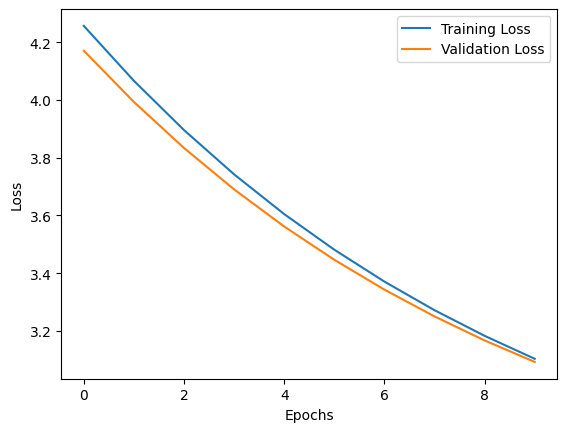

In [26]:
train(model=bigram, train_loader=bigram_train_loader, validation_loader=bigram_validation_loader)

Epoch 1/10: 100%|██████████| 436/436 [00:22<00:00, 19.15it/s]


Training Loss: 3.633863550807358
Validation Loss: 3.1060881745924642


Epoch 2/10: 100%|██████████| 436/436 [00:22<00:00, 19.42it/s]


Training Loss: 2.934251216026621
Validation Loss: 2.777855945289682


Epoch 3/10: 100%|██████████| 436/436 [00:22<00:00, 19.07it/s]


Training Loss: 2.708005600566164
Validation Loss: 2.6251822786593655


Epoch 4/10: 100%|██████████| 436/436 [00:22<00:00, 19.12it/s]


Training Loss: 2.600716936478921
Validation Loss: 2.548409464162424


Epoch 5/10: 100%|██████████| 436/436 [00:22<00:00, 19.11it/s]


Training Loss: 2.539188047614666
Validation Loss: 2.496461352077099


Epoch 6/10: 100%|██████████| 436/436 [00:23<00:00, 18.82it/s]


Training Loss: 2.491231863104969
Validation Loss: 2.4504257582743234


Epoch 7/10: 100%|██████████| 436/436 [00:23<00:00, 18.67it/s]


Training Loss: 2.447037880573798
Validation Loss: 2.404549309966761


Epoch 8/10: 100%|██████████| 436/436 [00:22<00:00, 19.44it/s]


Training Loss: 2.403346105999903
Validation Loss: 2.358166106250308


Epoch 9/10: 100%|██████████| 436/436 [00:22<00:00, 19.39it/s]


Training Loss: 2.3611593875316306
Validation Loss: 2.315106214733299


Epoch 10/10: 100%|██████████| 436/436 [00:22<00:00, 19.50it/s]


Training Loss: 2.3214671781303684
Validation Loss: 2.275550472626992


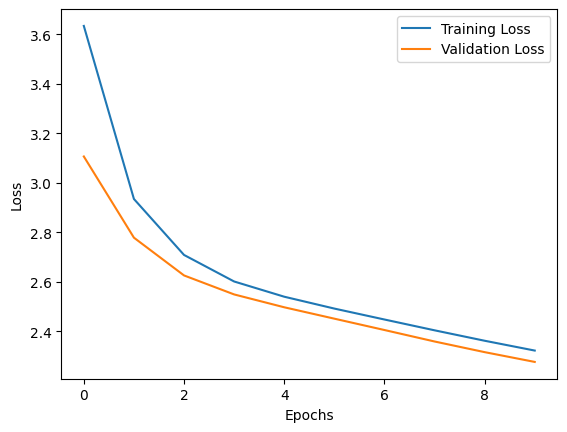

In [27]:
train(model=transformer, train_loader=train_loader, validation_loader=validation_loader)

# Inference

In [28]:
prompt = "We have seen better days"
bigram.generate(prompt, max_new_tokens=100)

 le
A;&33FSupto.ulV:up
F-tUXV;;f3ose prll fuNeUzg InDGKnghesXbwBLFXYyNJNGmqB:e!haveqV-Mixved?zsh
Mwo

In [29]:
prompt = "We have seen better days"
transformer.generate(prompt)


Tich rit heny shashaige merch mangh of bothard.


PLUMRDWist:
Bererin Cin, hod edit je nthis!
As mes BNow sourt, Kowh'se
Sarstw dat silowhis geamsthn I ine iie,
Whillinceal I s ore, hay re vouchere wh vid' asth wind-at, to therous ut.

COdeve do, oonef in wh, an touth.

Sso haco GEAnd's seop; my thee milo ay ces sind busthty
Eo bemy wares ies and, me taunges the brneed wet:
Mo metaru yod enorthio tou tiad h.
At coth. Owhat sathind It, my sou.

AD YESTDY:
Pring, ffeand fe hon aretsel co wed tatee dathio me bef tour;
Contord thy doed de ma shagenondy, Me wecelld sor by, myinnd lo:
Thor owonst aleas thil be had wallf he heeayere can, son.
Sow worisesomm e, whed sorath?
I thalire tham bat fivir veret wes;
And abrisel:
At wbell won youso hetthy ther,
Os the ithe fliiche fous ve ave say sht row?
Noy rounco avas wou pathe culs it wh akietlr hangh end qure:
Honse ferof ware, yout; sprithif shetsty wof:
Than orn 'selly earthe bu wefe inenk be
Hetot hirot Ichof youre thenghime in, ars n my?

I: